# Section 4.2 — Multiple linear regression

This notebook contains the code examples from [Section 4.2 Multiple linear regression]() from the **No Bullshit Guide to Statistics**.

#### Notebook setup

In [1]:
# load Python modules
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Figures setup
plt.clf()  # needed otherwise `sns.set_theme` doesn't work
from plot_helpers import RCPARAMS
# RCPARAMS.update({"figure.figsize": (10, 4)})   # good for screen
RCPARAMS.update({"figure.figsize": (5, 2.3)})  # good for print
sns.set_theme(
    context="paper",
    style="whitegrid",
    palette="colorblind",
    rc=RCPARAMS,
)

# High-resolution please
%config InlineBackend.figure_format = "retina"

# Where to store figures
DESTDIR = "figures/lm/multiple"

<Figure size 640x480 with 0 Axes>

In [3]:
from plot_helpers import savefigure

In [4]:
# set random seed for repeatability
np.random.seed(42)
#######################################################

## Definitions

## Doctors dataset

In [5]:
doctors = pd.read_csv("../datasets/doctors.csv")
doctors.shape

(156, 12)

In [6]:
doctors.head()

,permit,name,loc,work,age,exp,hours,caf,alc,weed,exrc,score
0,93273,Robert Snyder,rur,hos,26,2,21,2,0,5.0,0.0,63
1,90852,David Barnett,urb,cli,43,11,74,26,20,0.0,4.5,16
2,92744,Wesley Sanchez,urb,hos,30,1,63,25,1,0.0,7.0,58
3,73553,Anna Griffin,urb,eld,53,23,77,36,4,0.0,2.0,55
4,82441,Tiffany Richard,rur,cli,26,3,36,22,9,0.0,7.5,47


In [7]:
# doctors.columns
# cols = ["loc", "work", "age", "exp", "hours", "caf", "alc", "weed", "exrc", "score"]
# print("skipping columns", set(doctors.columns) - set(cols))
# docs = doctors[cols]
# lines = str(docs.head()).splitlines()
# for i, line in enumerate(lines):
#     print(line.replace("   ", " ", 1))

## Multiple linear regression model
$\newcommand{\Err}{ {\Large \varepsilon}}$

$$
   Y  = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \cdots + \beta_p x_p + \Err,
$$

where $p$ is the number of predictors
and $\Err$ represents Gaussian noise $\Err \sim \mathcal{N}(0,\sigma)$.


### Model assumptions



## Example: linear model for doctors' sleep scores

We want to know the influence of drinking alcohol, smoking weed, and exercise on sleep score?

In [8]:
import statsmodels.formula.api as smf

formula = "score ~ 1 + alc + weed + exrc"
lm2  = smf.ols(formula, data=doctors).fit()
lm2.params

Intercept    60.452901
alc          -1.800101
weed         -1.021552
exrc          1.768289
dtype: float64

### Partial regression plots

#### Partial regression plot for the predictor `alc` 

In [41]:
b0, b_alc, b_weed, b_exrc = lm2.params
#######################################################
avg_weed = doctors["weed"].mean()
avg_exrc = doctors["exrc"].mean()
avg_weed, avg_exrc

(0.6282051282051282, 5.387820512820513)

In [40]:
int_alc = b0 + b_weed*avg_weed + b_exrc*avg_exrc
int_alc

69.33837903371314

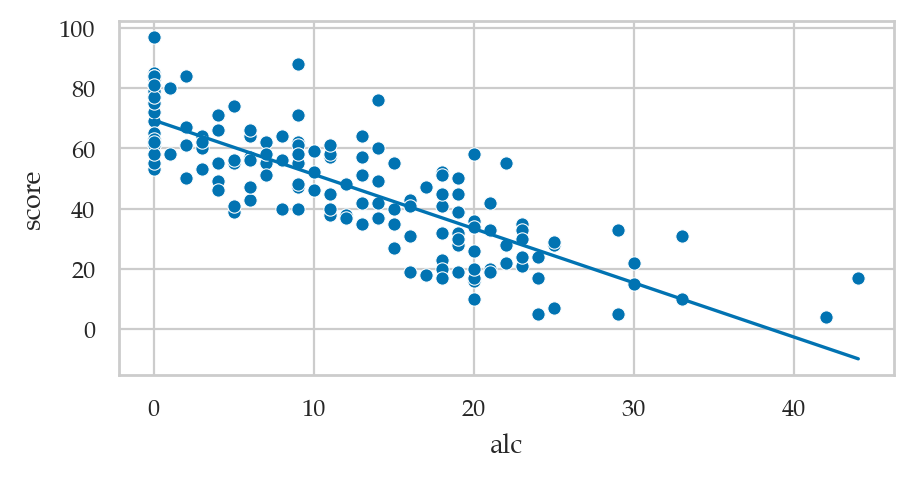

In [11]:
alcs = np.linspace(0, doctors["alc"].max())
scorehats_alc = int_alc + b_alc*alcs
sns.lineplot(x=alcs, y=scorehats_alc)
sns.scatterplot(data=doctors, x="alc", y="score");

#### Partial regression plot for the predictor `weed` 

weed intercept= 48.66738501700135 slope= -1.0215516597164425


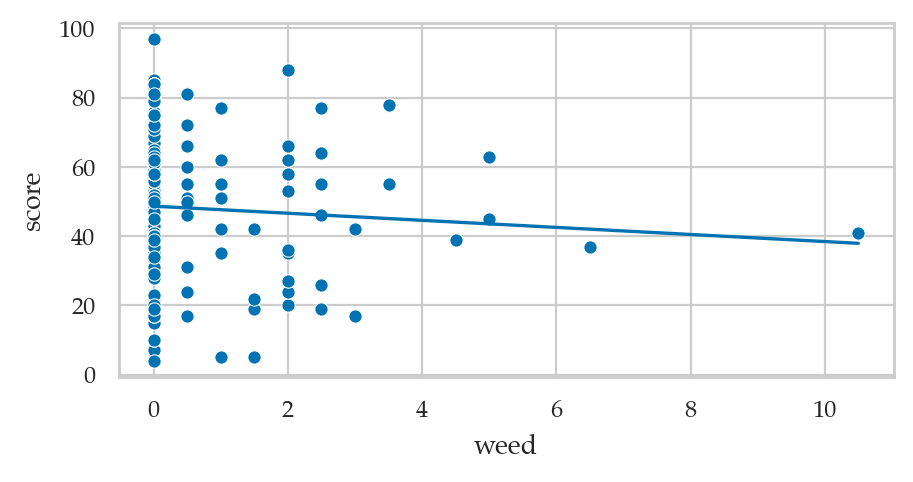

In [12]:
from plot_helpers import plot_lm_partial

plot_lm_partial(lm2, "weed")
sns.scatterplot(data=doctors, x="weed", y="score");

#### Partial regression plot for the predictor `exrc`

exrc intercept= 38.4984185910091 slope= 1.7682887564575607


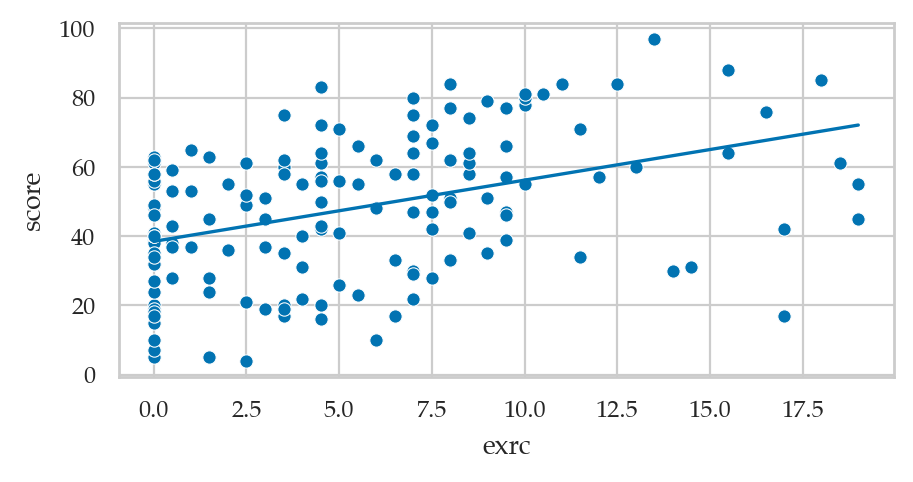

In [13]:
plot_lm_partial(lm2, "exrc")
sns.scatterplot(data=doctors, x="exrc", y="score");

alc intercept= 69.33837903371314 slope= -1.8001013152459402
weed intercept= 48.66738501700135 slope= -1.0215516597164425
exrc intercept= 38.4984185910091 slope= 1.7682887564575607
Saved figure to figures/lm/multiple/prediction_score_vs_alc_weed_exrc.pdf
Saved figure to figures/lm/multiple/prediction_score_vs_alc_weed_exrc.png


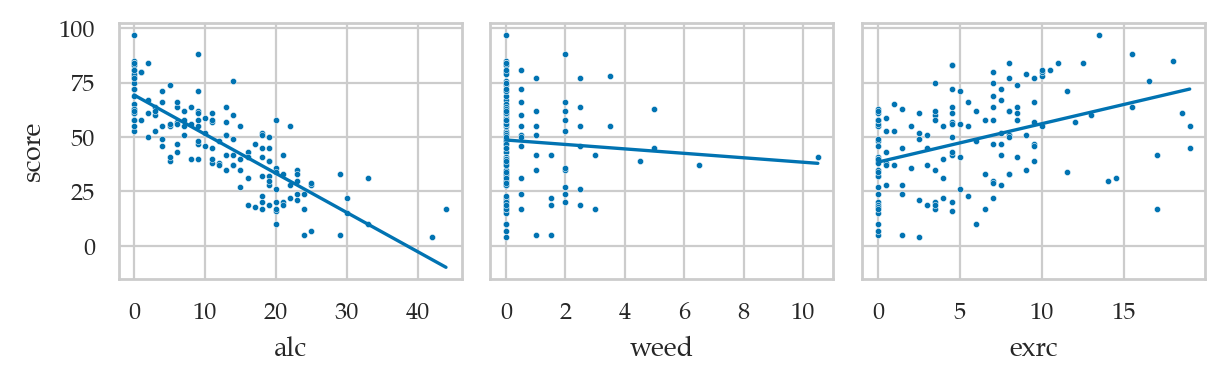

In [14]:
# leave simplified version after split to figures only

from plot_helpers import plot_lm_partial

with plt.rc_context({"figure.figsize":(6.2,2)}):
    fig, (ax1,ax2,ax3) = plt.subplots(1,3, sharey=True)
    # alc
    sns.scatterplot(data=doctors, x="alc", y="score", s=5, ax=ax1)
    ax1.set_xticks([0,10,20,30,40])
    plot_lm_partial(lm2, "alc", ax=ax1)
    # weed
    sns.scatterplot(data=doctors, x="weed", y="score", s=5, ax=ax2)
    ax2.set_xticks([0,2,4,6,8,10])
    plot_lm_partial(lm2, "weed", ax=ax2)
    # exrc
    sns.scatterplot(data=doctors, x="exrc", y="score", s=5, ax=ax3)
    ax3.set_xticks([0,5,10,15,20])
    plot_lm_partial(lm2, "exrc", ax=ax3)

    filename = os.path.join(DESTDIR, "prediction_score_vs_alc_weed_exrc.pdf")
    savefigure(plt.gcf(), filename)

#### Using `plot_partregress` from `statsmodels`

ALT. Way to obtain this using `plot_partregress` with empty `exog_others`


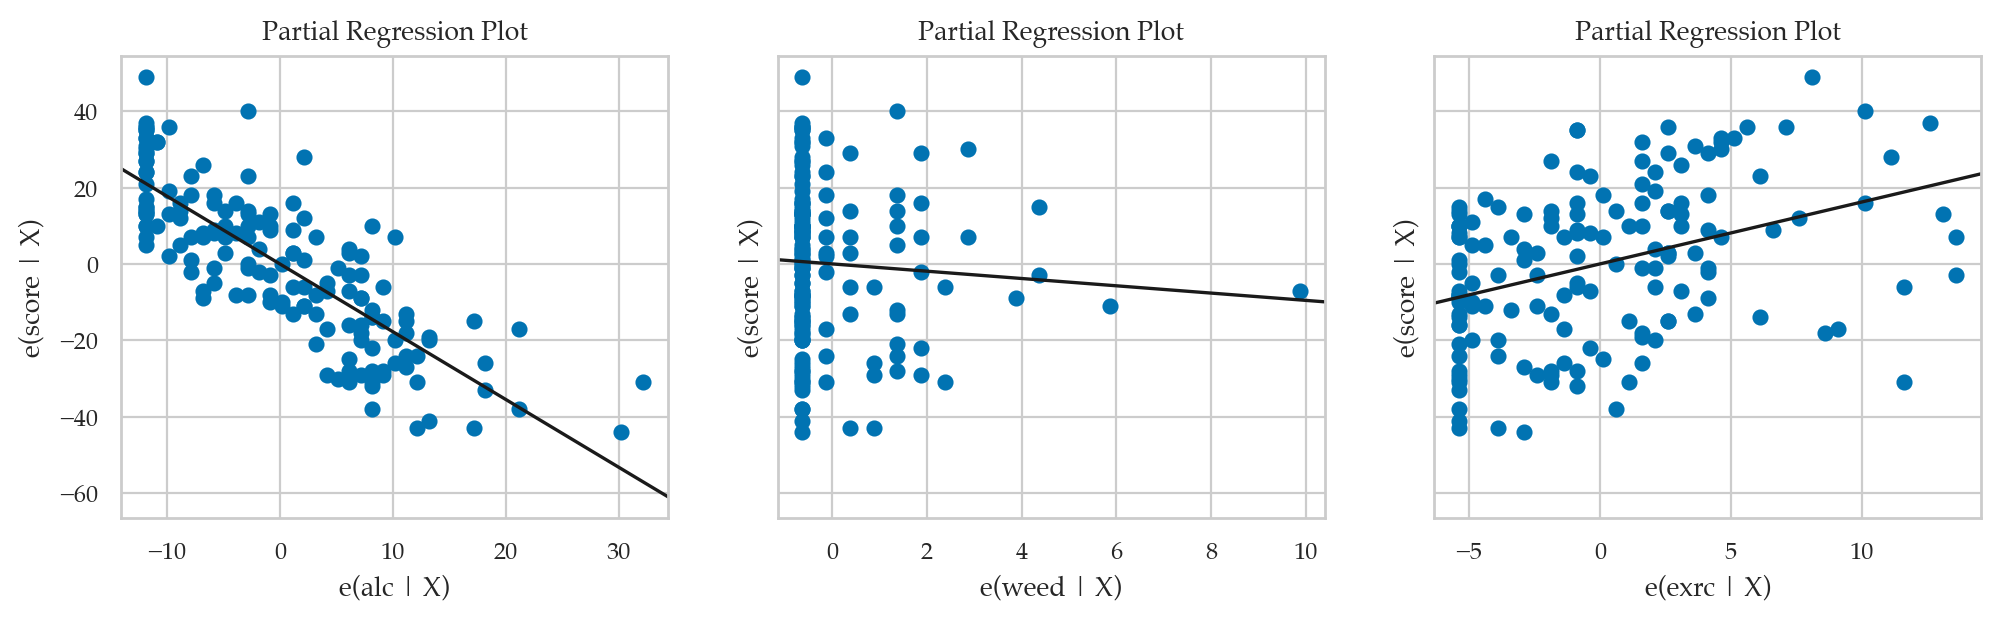

In [15]:
from statsmodels.graphics.api import plot_partregress

with plt.rc_context({"figure.figsize":(12,3)}):
    fig, (ax1,ax2,ax3) = plt.subplots(1,3, sharey=True)
    plot_partregress("score", "alc",  exog_others=[], data=doctors, obs_labels=False, ax=ax1)
    plot_partregress("score", "weed", exog_others=[], data=doctors, obs_labels=False, ax=ax2)
    plot_partregress("score", "exrc", exog_others=[], data=doctors, obs_labels=False, ax=ax3)

### Plot residuals

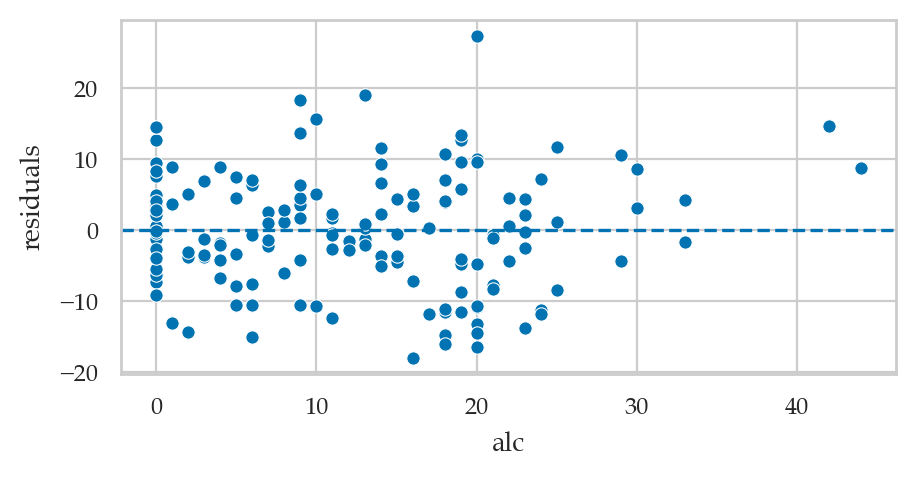

In [33]:
ax = sns.scatterplot(x=doctors["alc"], y=lm2.resid)
ax.axhline(y=0, color="b", linestyle="dashed")
ax.set_ylabel("residuals");

Saved figure to figures/lm/multiple/residuals_vs_alc_weed_exrc.pdf
Saved figure to figures/lm/multiple/residuals_vs_alc_weed_exrc.png


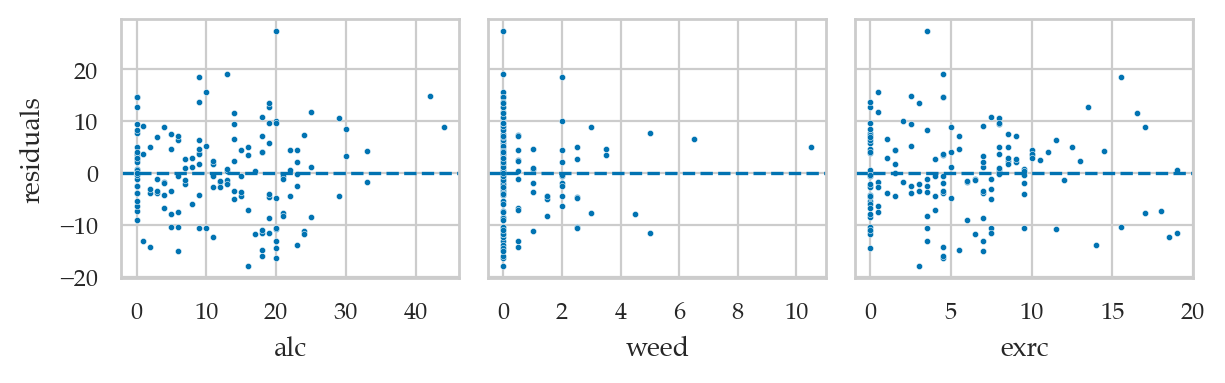

In [16]:
# leave simplified version after split to figures only

with plt.rc_context({"figure.figsize":(6.2,2)}):
    fig, (ax1,ax2,ax3) = plt.subplots(1, 3, sharey=True)
    ax1.set_ylabel("residuals")
    
    # residuals vs. alc
    sns.scatterplot(x=doctors["alc"], y=lm2.resid, s=5, ax=ax1)
    ax1.set_xticks([0,10,20,30,40])
    ax1.axhline(y=0, color="b", linestyle="dashed")
    
    # residuals vs. weed
    sns.scatterplot(x=doctors["weed"], y=lm2.resid, s=5, ax=ax2)
    ax2.set_xticks([0,2,4,6,8,10])
    ax2.axhline(y=0, color="b", linestyle="dashed")
    
    # residuals vs. exrc
    sns.scatterplot(x=doctors["exrc"], y=lm2.resid, s=5, ax=ax3)
    ax3.set_xticks([0,5,10,15,20])
    ax3.axhline(y=0, color="b", linestyle="dashed")
    
    filename = os.path.join(DESTDIR, "residuals_vs_alc_weed_exrc.pdf")
    savefigure(plt.gcf(), filename)

### Model summary table

In [26]:
from IPython.core.display import HTML
HTML(lm2.summary().as_html())

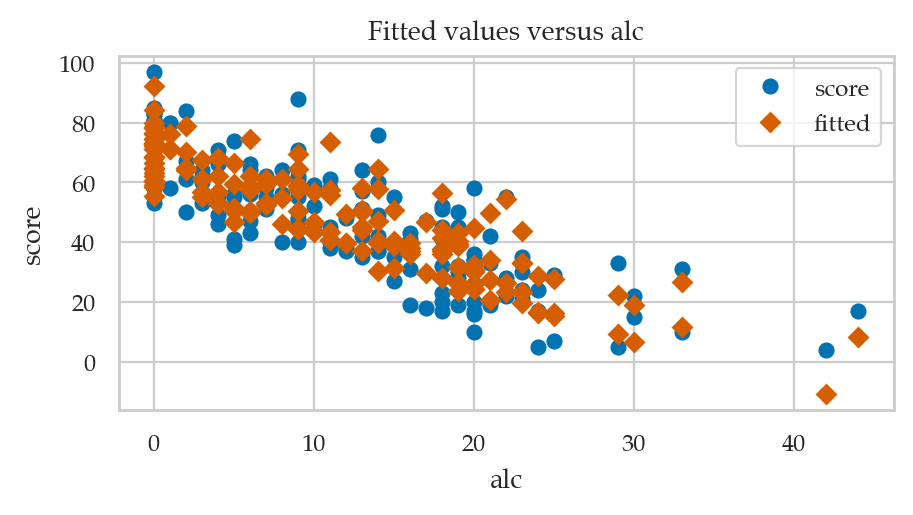

In [19]:
# What does this do?
from statsmodels.graphics.api import plot_fit
plot_fit(lm2, "alc", vlines=False);

## Explanations

### Feature engineering

Intercept           64.708568
age                  7.100854
np.power(age, 2)    -0.137302
dtype: float64
Saved figure to figures/lm/multiple/howell_quadratic_fit_height_vs_age.pdf
Saved figure to figures/lm/multiple/howell_quadratic_fit_height_vs_age.png


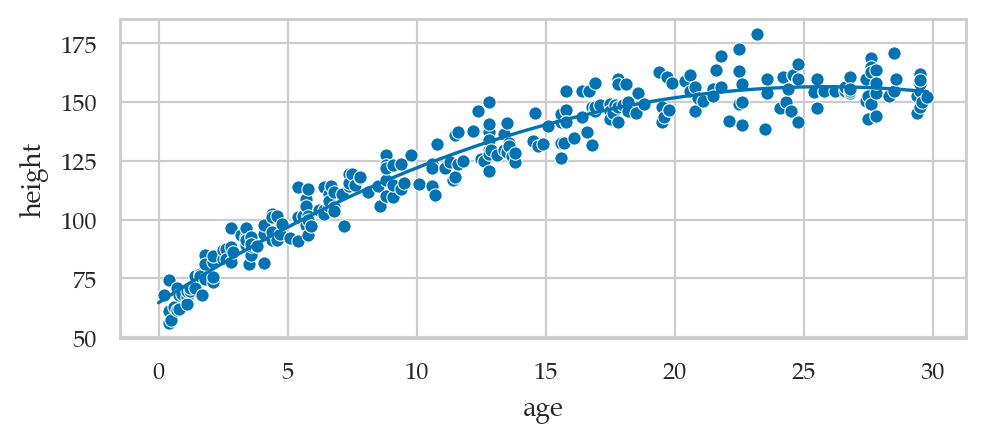

In [20]:
howell30 = pd.read_csv("../datasets/howell30.csv")

# Plot the data
sns.scatterplot(data=howell30, x="age", y="height")

# Fit quadratic model
formula = "height ~ 1 + age + np.power(age, 2)"
lmq = smf.ols(formula, data=howell30).fit()
print(lmq.params)

# Plot the best-fit quadratic model
int, blin, bquad = lmq.params.values
ages = np.linspace(0, howell30["age"].max())
heighthats = int + blin*ages + bquad*ages**2
sns.lineplot(x=ages, y=heighthats, color="b");


filename = os.path.join(DESTDIR, "howell_quadratic_fit_height_vs_age.pdf")
savefigure(plt.gcf(), filename)

## Discussion

## Exercises

## Links